<a href="https://colab.research.google.com/github/campu1992/price_prediction_ai/blob/main/Generative_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance


In [ ]:
model.save('modelo_appl_1h.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('/content/modelo_mercados.h5')

[*********************100%%**********************]  1 of 1 completed


Epoch 1/80
56/56 [==============================] - 6s 29ms/step - loss: 0.1003 - val_loss: 1.2515
Epoch 2/80
56/56 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.8788
Epoch 3/80
56/56 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.3707
Epoch 4/80
56/56 [==============================] - 1s 15ms/step - loss: 0.0065 - val_loss: 0.5531
Epoch 5/80
56/56 [==============================] - 2s 38ms/step - loss: 0.0054 - val_loss: 0.6074
Epoch 6/80
56/56 [==============================] - 2s 39ms/step - loss: 0.0059 - val_loss: 0.4994
Epoch 7/80
56/56 [==============================] - 1s 19ms/step - loss: 0.0054 - val_loss: 0.3818
Epoch 8/80
56/56 [==============================] - 1s 14ms/step - loss: 0.0058 - val_loss: 0.3323
Epoch 9/80
56/56 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.5046
Epoch 10/80
56/56 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.3298
Epoch 11/

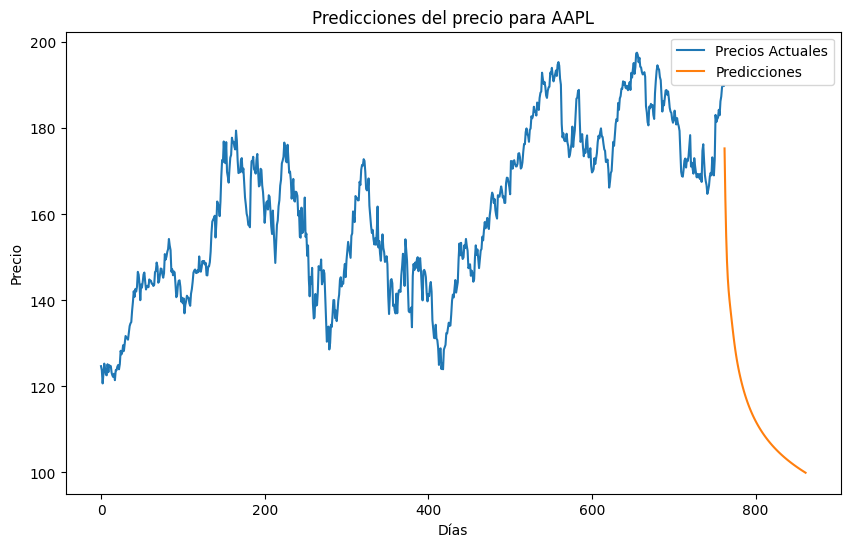

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import yfinance as yf
import matplotlib.pyplot as plt

# Función para cargar datos de Yahoo Finance
def load_data(symbol, start_date, end_date, interval='1d'):
    data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
    return data['Adj Close'].values

# Función para normalizar datos
def normalize_data(data, mean=None, std=None):
    if mean is None:
        mean = data.mean()
    if std is None:
        std = data.std()
    return (data - mean) / std, mean, std

# Función para dividir datos en entrenamiento y validación
def split_data(data, train_ratio=0.7):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:]
    return train_data, val_data

# Función para generar secuencias de datos para el modelo
def generate_sequences(data, lookback, step):
    X = []
    y = []
    for i in range(lookback, len(data) - 1, step):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Definir símbolo del activo, fechas y parámetros
symbol = 'AAPL'
start_date = '2014-04-20'
end_date = '2024-05-20'
lookback = 10
step = 1  # Step value should be a positive integer

# Cargar datos desde Yahoo Finance
data = load_data(symbol, start_date, end_date)

# Dividir los datos en conjuntos de entrenamiento y validación
train_data, val_data = split_data(data)

# Normalizar los datos
train_data_norm, train_mean, train_std = normalize_data(train_data)
val_data_norm, _, _ = normalize_data(val_data, train_mean, train_std)

# Generar secuencias de datos para el modelo
X_train, y_train = generate_sequences(train_data_norm, lookback=lookback, step=step)
X_val, y_val = generate_sequences(val_data_norm, lookback=lookback, step=step)

# Crear el modelo
model = tf.keras.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    layers.LSTM(50),
    layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val))

# Definir parámetros de simulación
horizonte_tiempo = 100  # Días

# Generar precios predichos
predicciones = []
input_sequence = val_data_norm[-lookback:]

for i in range(horizonte_tiempo):
    input_sequence = input_sequence.reshape((1, lookback, 1))
    pred = model.predict(input_sequence)[0, 0]
    predicciones.append(pred)
    input_sequence = np.append(input_sequence[0, 1:], pred).reshape(lookback)

# Desnormalizar los precios predichos
def denormalize_data(data, mean, std):
    return (data * std) + mean

predicciones = np.array(predicciones)
predicciones_desnormalizadas = denormalize_data(predicciones, train_mean, train_std)

# Mostrar los resultados de la simulación
def plot_prices(symbol, actual_prices, predicted_prices, pred_start_date):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices, label='Precios Actuales')
    plt.plot(range(len(actual_prices), len(actual_prices) + len(predicted_prices)), predicted_prices, label='Predicciones')
    plt.title(f'Predicciones del precio para {symbol}')
    plt.xlabel('Días')
    plt.ylabel('Precio')
    plt.legend()
    plt.show()

# Concatenar datos actuales con predicciones para mostrar en un solo gráfico
actual_prices = denormalize_data(val_data_norm, train_mean, train_std)
plot_prices(symbol, actual_prices, predicciones_desnormalizadas, end_date)


[*********************100%%**********************]  1 of 1 completed


Epoch 1/80
63/63 [==============================] - 4s 18ms/step - loss: 0.1643 - val_loss: 0.0570
Epoch 2/80
63/63 [==============================] - 1s 8ms/step - loss: 0.0072 - val_loss: 0.0512
Epoch 3/80
63/63 [==============================] - 1s 9ms/step - loss: 0.0060 - val_loss: 0.0537
Epoch 4/80
63/63 [==============================] - 1s 8ms/step - loss: 0.0054 - val_loss: 0.0414
Epoch 5/80
63/63 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0240
Epoch 6/80
63/63 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0209
Epoch 7/80
63/63 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0295
Epoch 8/80
63/63 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0212
Epoch 9/80
63/63 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0158
Epoch 10/80
63/63 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0179
Epoch 11/80
63/63 

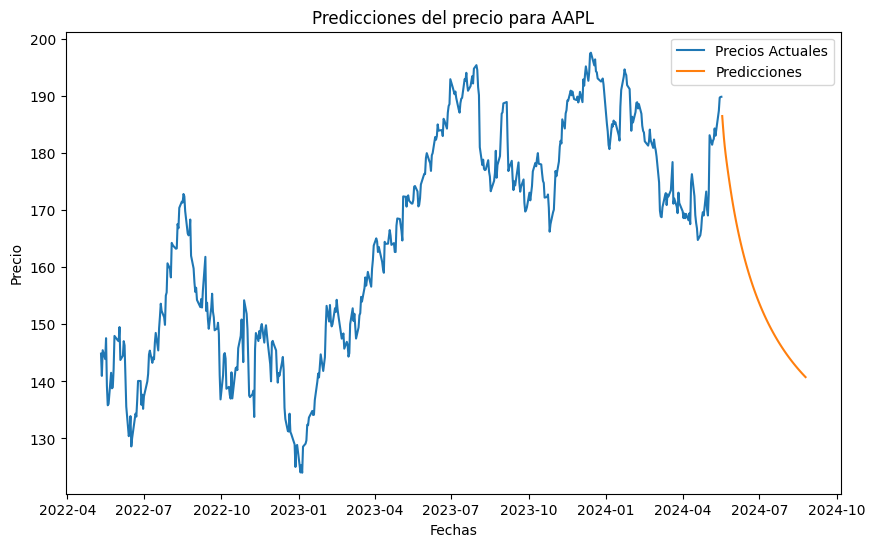

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import yfinance as yf
import matplotlib.pyplot as plt

# Función para cargar datos de Yahoo Finance
def load_data(symbol, start_date, end_date, interval='1d'):
    data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
    return data['Adj Close'].values, data.index

# Función para normalizar datos
def normalize_data(data, mean=None, std=None):
    if mean is None:
        mean = data.mean()
    if std is None:
        std = data.std()
    return (data - mean) / std, mean, std

# Función para dividir datos en entrenamiento y validación
def split_data(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:]
    return train_data, val_data

# Función para generar secuencias de datos para el modelo
def generate_sequences(data, lookback, horizon):
    X = []
    y = []
    for i in range(lookback, len(data) - horizon + 1):
        X.append(data[i-lookback:i])
        y.append(data[i:i+horizon])
    return np.array(X), np.array(y)

# Definir símbolo del activo, fechas y parámetros
symbol = 'AAPL'
start_date = '2014-04-20'
end_date = '2024-05-20'
lookback = 10
horizon = 5  # Número de pasos futuros a predecir

# Cargar datos desde Yahoo Finance
data, dates = load_data(symbol, start_date, end_date)

# Dividir los datos en conjuntos de entrenamiento y validación
train_data, val_data = split_data(data)
train_dates, val_dates = split_data(dates)

# Normalizar los datos
train_data_norm, train_mean, train_std = normalize_data(train_data)
val_data_norm, _, _ = normalize_data(val_data, train_mean, train_std)

# Añadir dimensión extra para ser compatible con LSTM
train_data_norm = train_data_norm[:, np.newaxis]
val_data_norm = val_data_norm[:, np.newaxis]

# Generar secuencias de datos para el modelo
X_train, y_train = generate_sequences(train_data_norm, lookback, horizon)
X_val, y_val = generate_sequences(val_data_norm, lookback, horizon)

# Crear el modelo Seq2Seq
encoder_inputs = tf.keras.Input(shape=(lookback, 1))
encoder_lstm = layers.LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = tf.keras.Input(shape=(horizon, 1))
decoder_lstm = layers.LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = layers.Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
decoder_input_data = np.zeros((len(X_train), horizon, 1))
model.fit([X_train, decoder_input_data], y_train, epochs=80, validation_data=([X_val, np.zeros((len(X_val), horizon, 1))], y_val))

# Definir horizonte de tiempo para predicción
horizonte_tiempo = 100  # Número de días a predecir

# Generar precios predichos
def predict_sequence(model, input_sequence, horizonte_tiempo, lookback, horizon):
    predictions = []
    current_sequence = input_sequence

    for _ in range(horizonte_tiempo):
        current_sequence_reshaped = current_sequence.reshape((1, lookback, 1))
        decoder_input = np.zeros((1, horizon, 1))
        predicted_sequence = model.predict([current_sequence_reshaped, decoder_input])
        predictions.append(predicted_sequence[0, 0, 0])
        current_sequence = np.append(current_sequence[1:], predicted_sequence[0, 0, 0])

    return predictions

# Predecir futuros precios
predicciones = predict_sequence(model, val_data_norm[-lookback:], horizonte_tiempo, lookback, horizon)

# Convertir predicciones a array de NumPy
predicciones = np.array(predicciones)

# Desnormalizar los precios predichos
def denormalize_data(data, mean, std):
    return (data * std) + mean

predicciones_desnormalizadas = denormalize_data(predicciones, train_mean, train_std)

# Generar fechas para las predicciones
predicted_dates = pd.date_range(start=val_dates[-1], periods=horizonte_tiempo + 1, inclusive='right')

# Mostrar los resultados de la simulación
def plot_prices(symbol, actual_prices, predicted_prices, actual_dates, predicted_dates):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_dates, actual_prices, label='Precios Actuales')
    plt.plot(predicted_dates, predicted_prices, label='Predicciones')
    plt.title(f'Predicciones del precio para {symbol}')
    plt.xlabel('Fechas')
    plt.ylabel('Precio')
    plt.legend()
    plt.show()

# Concatenar datos actuales con predicciones para mostrar en un solo gráfico
actual_prices = denormalize_data(val_data_norm, train_mean, train_std)
plot_prices(symbol, actual_prices, predicciones_desnormalizadas, val_dates, predicted_dates)